In [313]:
import numpy as np
import pandas as pd
import cvxpy as cp
from geopy import distance
import time
from python_tsp.exact import solve_tsp_dynamic_programming


In [314]:
data = pd.read_csv('../Dataset/fri26_d.txt',delim_whitespace=True,header=None).to_numpy()

In [315]:
np.random.seed(42)
import random

n = 15  # number of points to generate
points = []

for i in range(n):
    lat = round(random.uniform(-90, 90), 6)
    lon = round(random.uniform(-180, 180), 6)
    points.append((lat, lon))

print(points)


################################################
# Building distance matrix
################################################
n = len(points)
C = np.zeros((n,n))

for i in range(0, n):
    for j in range(0, len(points)):
        C[i,j] = distance.distance(points[i], points[j]).km

# Showing distance matrix
print('Distance Matrix is:\n')
print(np.round(C,4))

[(-60.485814, 54.255392), (42.146226, -80.766661), (43.011783, 157.533311), (53.804065, -63.554957), (-8.430854, 108.065752), (78.892886, -63.292731), (-51.563937, 32.495276), (42.863211, 23.720077), (36.964729, 114.587972), (24.544075, 57.819267), (-20.415646, -2.948854), (70.236611, 111.343301), (25.893276, -5.108743), (-37.348502, -73.438034), (-59.133107, -166.619094)]
Distance Matrix is:

[[    0.     16376.8701 14721.7407 16321.7927  7274.6252 17089.577
   1668.5991 11787.9868 12112.6268  9429.3313  6272.9394 15178.6808
  10970.5456  8164.5264  6275.0342]
 [16376.8701     0.      8923.6942  1816.0008 16170.3012  4163.672
  15003.3339  7949.5419 11106.4048 11487.4973 10554.2908  7502.0552
   6987.5798  8834.4792 13684.0325]
 [14721.7407  8923.6942     0.      8585.8831  7579.669   6216.7513
  15855.7477  9438.5757  3687.6214  8928.4293 16914.3096  3966.8291
  12171.539  15702.0872 11791.8034]
 [16321.7927  1816.0008  8585.8831     0.     14916.6466  2797.434
  14672.0612  6164.563

In [316]:
# Generate a random SDP.
n = C.shape[0]
np.random.seed(1)
# C = data
e = np.ones((n,1))
I = np.eye(n)
J = np.ones((n,n))
constant =  2-2*np.cos((2*np.pi)/n)
# Define and solve the CVXPY problem.
# Create a symmetric matrix variable.
X = cp.Variable((n,n), symmetric=True)
# The operator >> denotes matrix inequality.
constraints = [
    X[i][i] == 0 for i in range(n)
]
constraints += [
    X@e == 2*e
]
constraints += [
    X[i][j] >= 0 for i in range(n) for j in range(n)
]
constraints += [
    X[i][j] <= 1 for i in range(n) for j in range(n)
]
constraints += [
    2*I-X+J-(constant*I) >> 0
]
prob = cp.Problem(cp.Minimize(1/2*cp.trace(C @ X)),
                  constraints)
start_time = time.time()
prob.solve(verbose=False)
print("--- %s seconds ---" % (time.time() - start_time))
# Print result.
print("The optimal value is", prob.value)
# print("A solution X is")
# print(X.value)


--- 0.865684986114502 seconds ---
The optimal value is 67519.30701060542


In [317]:
# start_time = time.time()
# permutation, distance2 = solve_tsp_dynamic_programming(C)
# print("--- %s seconds ---" % (time.time() - start_time))

In [318]:
# permutation

In [319]:
################################################
# Solving the integer programming problem
################################################
# Define the decision variables
x = cp.Variable((n, n), boolean=True)

# Define the objective function
obj = cp.Minimize(cp.sum(cp.multiply(C, x)))

# Define the constraints
constraints = []
for i in range(n):
    constraints.append(cp.sum(x[i, :]) == 1)  # each city is visited exactly once
for j in range(n):
    constraints.append(cp.sum(x[:, j]) == 1)  # each city is left exactly once
for i in range(n):
    for j in range(n):
        constraints.append(x[i, j] + x[j, i] <= 1)  # prevent subtours

# Define the problem and solve it
prob = cp.Problem(obj, constraints)
start_time = time.time()
prob.solve()
print("--- %s seconds ---" % (time.time() - start_time))
# Print the optimal tour and its length
tour = [0]
i = 0
while len(tour) < n:
    j = np.argmax(x.value[i, :])
    tour.append(j)
    i = j
tour.append(0)
print('Optimal tour:', tour)
print('Length:', round(obj.value))

--- 0.16625475883483887 seconds ---
Optimal tour: [0, 14, 13, 10, 6, 0, 14, 13, 10, 6, 0, 14, 13, 10, 6, 0]
Length: 67513


In [320]:
def thirdMax(nums):
    nums.sort(reverse = True)
    count = 1
    previous = nums[0]

    for i in range(len(nums)):
        if nums[i] != previous:
            count = count + 1
            previous = nums[i]
        if count == 2:
            return nums[i]
    return nums[0]

In [321]:
def thirdMax(nums):
    nums.sort(reverse = True)
    count = 1
    previous = nums[0]

    for i in range(len(nums)):
        if nums[i] != previous:
            count = count + 1
            previous = nums[i]
        if count == 3:
            return nums[i]
    return nums[0]

In [322]:
Res = X.value
out = [[1 if X.value[i][j]>thirdMax(X.value[i].tolist()) else 0 for i in range(X.shape[0])]for j in range(X.shape[1])]

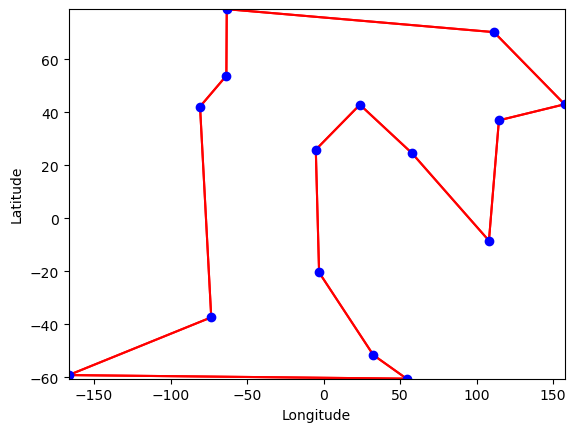

In [323]:
import numpy as np
import matplotlib.pyplot as plt

# Define the latitude and longitude of the points
lat = [i[0] for i in points]
lon = [i[1] for i in points]

# Define the adjacency matrix
adj_matrix = np.array(out)

# Plot the points and the edges
plt.scatter(lon, lat, color='b', zorder=2)
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if adj_matrix[i,j] == 1:
            plt.plot([lon[i], lon[j]], [lat[i], lat[j]], color='r', zorder=1)

# Set the axis limits and labels
plt.xlim(min(lon)-0.02, max(lon)+0.02)
plt.ylim(min(lat)-0.02, max(lat)+0.02)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


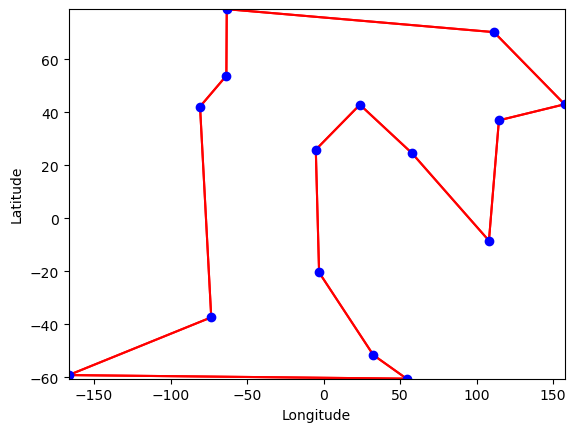

In [324]:
import numpy as np
import matplotlib.pyplot as plt

# Define the latitude and longitude of the points
lat = [i[0] for i in points]
lon = [i[1] for i in points]

# Define the adjacency matrix
adj_matrix = np.array(out)

# Plot the points and the edges
plt.scatter(lon, lat, color='b', zorder=2)
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if adj_matrix[i,j] == 1:
            plt.plot([lon[i], lon[j]], [lat[i], lat[j]], color='r', zorder=1)

# Set the axis limits and labels
plt.xlim(min(lon)-0.02, max(lon)+0.02)
plt.ylim(min(lat)-0.02, max(lat)+0.02)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()
